In [1]:
import numpy as np
import pandas as pd
from htke.load_data import *
from htke.process_ir_data import *
from htke.load_conditions import *
from htke.spka import *
from htke.rpka import *
pd.options.mode.chained_assignment = None  # default='warn' stops the slice error

In [4]:
%pwd
%cd ir_data\GL-06-53-3

C:\Users\Paul Dingwall\Documents\github\htke\ir_data\GL-06-53-3


<AxesSubplot:xlabel='Relative Time'>

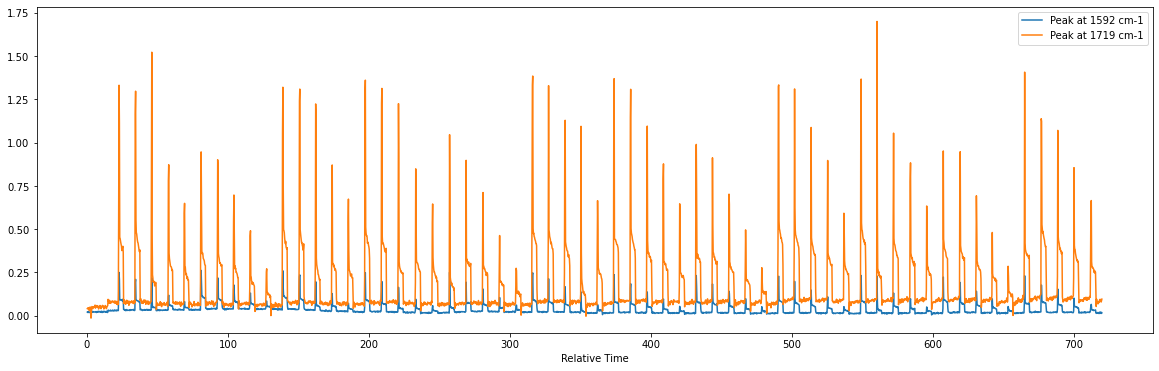

In [5]:
# Instantiate class
Data()

# Load data to dataframe
ir_data = Data.read()

# Visualise the data
Data.plot(ir_data)

#ir_data

In [6]:
#https://stackoverflow.com/questions/71575174/optimizing-asymmetrically-reweighted-penalized-least-squares-smoothing-from-mat
def baseline_arPLS(y, lam, ratio):
    # Estimate baseline with arPLS
    N = len(y)
    k = [np.ones(N), -2*np.ones(N-1), np.ones(N-2)]
    offset = [0, 1, 2]
    D = diags(k, offset).toarray()
    H = lam * np.matmul(D.T, D) 
    w_ = np.ones(N)
    i = 0
    N_iterations = 100
    while i < N_iterations:
        W = spdiags(w_, 0, N, N, format='csr')
        # Cholesky decomposition
        C = cholesky(W + H)
        z_ = spsolve(C.T, w_ * y)
        z = spsolve(C, z_)
        d = y - z 
        # make d- and get w^t with m and s 
        dn = d[d<0]
        m = np.mean(dn)
        s = np.std(dn)
        wt = 1. / (1 + np.exp(2 * (d - (2*s-m)) / s))
        # check exit condition and backup 
        norm_wt, norm_w = norm(w_-wt), norm(w_)
        if (norm_wt / norm_w) < ratio:
            break 
   
        w_ = wt
        i += 1
    return(z)

In [7]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

In [8]:
def baseline_correction4(raman_spectra,lam,p,niter=10):
    #according to "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens
    number_of_spectra = raman_spectra.index.size

    #this is the code for the fitting procedure        
    L = len(raman_spectra.columns)
    w = np.ones(raman_spectra.shape[0]*raman_spectra.shape[1])

    D = sparse.block_diag(np.tile(sparse.diags([1,-2,1],[0,-1,-2],shape=(L,L-2)),number_of_spectra),format='csr')

    raman_spectra_flattened = raman_spectra.values.ravel()

    for jj in range(int(niter)):
        W = sparse.diags(w,format='csr')
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z,w*raman_spectra_flattened,permc_spec='NATURAL')
        w = p * (raman_spectra_flattened > z) + (1-p) * (raman_spectra_flattened < z)
    #end of fitting procedure

    baseline_data = pd.DataFrame(z.reshape(number_of_spectra,-1),index=raman_spectra.index,columns=raman_spectra.columns)
    return baseline_data

In [9]:
#THIS IS THE ONE THAT I USED

#https://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data
def baseline_correction_new(data: pd.Series, lam: int=200, p: float=0.01, niter: int=10) -> pd.Series:
    #this is the code for the fitting procedure        
    L = len(data)
    w = np.ones(L)
    D = sparse.diags([1,-2,1], [0,-1,-2], shape=(L,L-2))

    for jj in range(int(niter)):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*data.astype(np.float64))
        w = p * (data > z) + (1-p) * (data < z)

    return pd.Series(z)

In [10]:
# Apply correction
correction = baseline_correction_new(ir_data['Peak at 1592 cm-1'])
corrected_baseline = ir_data['Peak at 1592 cm-1'] - correction

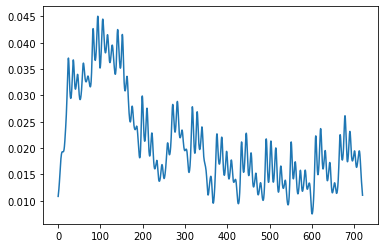

In [11]:
plt.plot(ir_data['Relative Time'], correction)

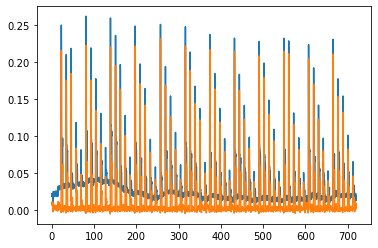

In [12]:
plt.plot(ir_data['Relative Time'], ir_data['Peak at 1592 cm-1'])
plt.plot(ir_data['Relative Time'], corrected_baseline)

## Explore

In [28]:
#THIS IS THE ONE THAT I USED

#https://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data
def baseline_correction_new(data, lam=200, p=0.01, niter=10):
    #this is the code for the fitting procedure        
    L = len(data)
    w = np.ones(L)
    D = sparse.diags([1,-2,1], [0,-1,-2], shape=(L,L-2))

    for jj in range(int(niter)):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*data.astype(np.float64))
        w = p * (data > z) + (1-p) * (data < z)

    return pd.Series(z)

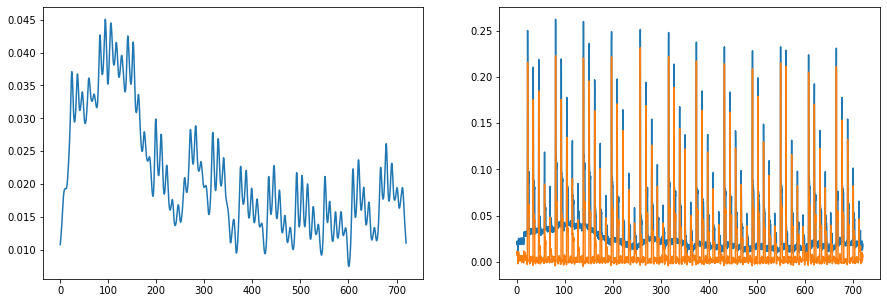

In [40]:
# Apply correction
correction = baseline_correction_new(ir_data['Peak at 1592 cm-1'], 200, 0.01, 10)
corrected_baseline = ir_data['Peak at 1592 cm-1'] - correction

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(ir_data['Relative Time'], correction)

ax2.plot(ir_data['Relative Time'], ir_data['Peak at 1592 cm-1'])
ax2.plot(ir_data['Relative Time'], corrected_baseline)

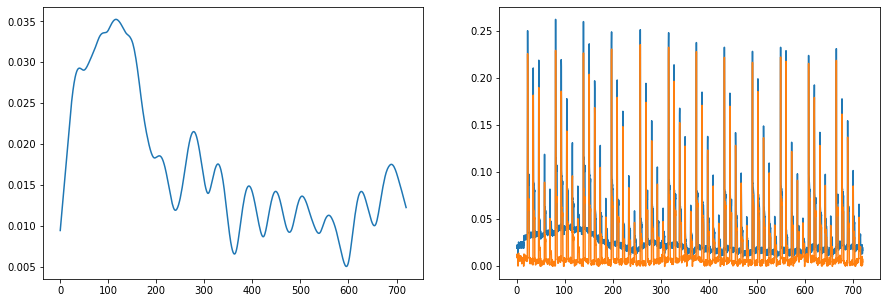

In [49]:
# Apply correction
correction = baseline_correction_new(ir_data['Peak at 1592 cm-1'], 2000, 0.0001, 10)
corrected_baseline = ir_data['Peak at 1592 cm-1'] - correction

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(ir_data['Relative Time'], correction)

ax2.plot(ir_data['Relative Time'], ir_data['Peak at 1592 cm-1'])
ax2.plot(ir_data['Relative Time'], corrected_baseline)